# Challenge N°3 - Algoritmos de clasificación

La secreción de sideróforos es una de las estrategias que presentan los microorganismos para adquirir hierro del ambiente a través de la formación de complejos con $\text{Fe}^{+3}$, los cuáles son internalizados por determinados receptores ([Kramer et al, 2019](https://www.nature.com/articles/s41579-019-0284-4)). Estas moléculas - metabolitos secundarios - pueden clasificarse de acuerdo al ligando de oxígeno que coordina el enlace con $\text{Fe}^{+3}$, entre los cuáles se encuentra los catecolatos, hidroximatos, carboxilatos, entre otros ([Rapti et al, 2021](https://link.springer.com/chapter/10.1007/978-3-030-69411-1_14)). En el presente notebook, se plantean algoritmos de clasificación que permiten clasificar un sideróforo según el ligando de oxígeno a partir de los [descriptores moleculares](https://github.com/inefable12/siderophores_database/blob/main/Siderophore_DB1.csv) del compuesto a analizar, tales como
* Hybrid EState-VSA descriptors (e.g MaxEStateIndex)
* QED (quantitative estimation of drug-likeness)
* Descriptores topológicos (e.g chi0, 
* Descriptores generales (e.g peso molecular, número de electrones de valencia, carga parcial)

## Análisis exploratorio de datos

Importamos las librerías que utilizaremos para el análisis exploratorio de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importamos el dataset

In [2]:
!git clone https://github.com/inefable12/siderophores_database

fatal: destination path 'siderophores_database' already exists and is not an empty directory.


In [3]:
cd /content/siderophores_database

/content/siderophores_database


In [4]:
!ls

README.md	     Siderophore_DB2.csv  Siderophore_DB.csv
Siderophore_DB1.csv  Siderophore_DB3.csv


In [5]:
from os import listdir
path = '/content/siderophores_database'
from os.path import isfile, join
files = [f for f in listdir(path) if isfile(join(path, f))]

# Archivo README.md no corresponde a data
files.remove('README.md')

# Ordenar la data para facilitar su manipulación
files[1], files[2], files[3] = files[2], files[3], files[1]
files

['Siderophore_DB.csv',
 'Siderophore_DB1.csv',
 'Siderophore_DB2.csv',
 'Siderophore_DB3.csv']

Importamos el dataset que contiene las etiquetas de las clases (hydroxamate, catecholate, carboxylate, y demás).

In [6]:
siderophores_0 = pd.read_csv(files[0])
np.shape(siderophores_0)

(221, 14)

Observamos que el dataset se compone de 221 sideróforos y 14 características asociados a cada uno.

In [7]:
siderophores_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    221 non-null    object
 1   Compounds             221 non-null    object
 2   Microorganism         149 non-null    object
 3   hydroxamate           221 non-null    int64 
 4   catecholate           221 non-null    int64 
 5   a-hydroxycarboxylate  221 non-null    int64 
 6   carboxylate           221 non-null    int64 
 7   phenolate             221 non-null    int64 
 8   citrate               221 non-null    int64 
 9   other                 221 non-null    int64 
 10  SMILES                221 non-null    object
 11  validate smiles       221 non-null    bool  
 12  SMARTS                221 non-null    object
 13  SELFIES               221 non-null    object
dtypes: bool(1), int64(7), object(6)
memory usage: 22.8+ KB


Observamos que las etiquetas de los microorganismos no se encuentran completas. Sin embargo, como la clasificación se realizará a partir de descriptores moleculares, no se considerará dicha columna. Asimismo, las columnas de *SMILE*, *validated smiles*, *SMARTS* y *SELFIES* no se considerarán para la clasificación. Sin embargo, estas pueden ser utilizadas para calcular descriptores moleculares en caso el respectivo dataset se encuentre incompleto ([rdkit](https://www.rdkit.org/docs/GettingStartedInPython.html)). Por lo tanto, de este dataset solo se extraerán los grupos funcionales de cada sideróforo, que corresponden a las etiquetas de cada clase.

## Clasificación binaria de sideróforos

Como primer ejercicio, se implementarán modelos de machine learning para realizar una clasificación binaria considerando solo un grupo funcional.

In [8]:
# Evaluamos el balance de clases cualitativamente
for key in siderophores_0.keys()[3:10]:
  print(key)
  unique, counts = np.unique(siderophores_0[key], return_counts=True)
  print(str(list(zip(unique, counts))) + '\n')

hydroxamate
[(0, 91), (1, 18), (2, 22), (3, 85), (4, 5)]

catecholate
[(0, 153), (1, 23), (2, 27), (3, 18)]

a-hydroxycarboxylate
[(0, 206), (1, 7), (2, 8)]

carboxylate
[(0, 148), (1, 63), (2, 8), (3, 1), (4, 1)]

phenolate
[(0, 202), (1, 18), (2, 1)]

citrate
[(0, 202), (1, 16), (2, 3)]

other
[(0, 204), (1, 17)]



Como realizaremos una clasificación binaria, podemos asumir que todos los valores > 0 pertenecen a una misma clase. En ese caso, elegiremos la clase *hydroxymate* para realizar la clasificación debido a que presente una proporción relativamente equitativa entre valores iguales y diferentes a 0. Luego, "1" significará que el compuesto presenta al menos un grupo hidroximato, mientras que "0" significará que el compuesto no presenta ni un grupo.

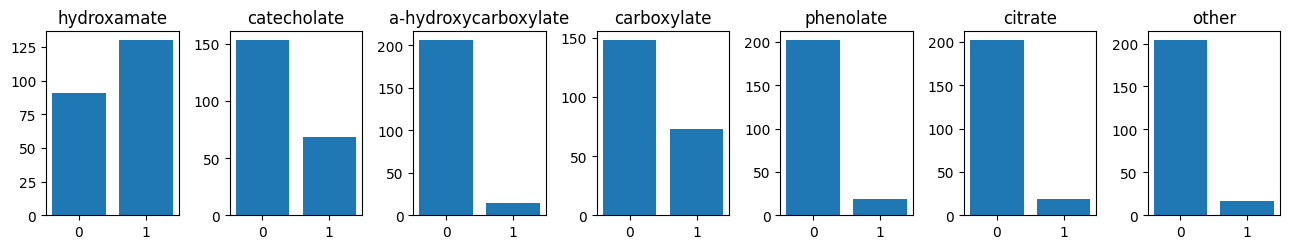

In [9]:
fig, axs = plt.subplots(1,7, figsize = (13,2.6))
for i, key in enumerate(siderophores_0.keys()[3:10]):
  _, counts = np.unique(siderophores_0[key], return_counts=True)
  axs[i].bar([0,1], [counts[0], np.sum(counts[1:])])
  axs[i].set_title(key)
plt.tight_layout()
plt.show()

In [10]:
# Definimos el target hydroxymate
y = siderophores_0['hydroxamate']

Por otro lado, los datos correspondientes al dataset *Siderophores_DB1.csv* corresponden a descriptores moleculares.

In [11]:
siderophores_1 = pd.read_csv(files[1])
siderophores_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 119 entries, ID to fr_phenol_noOrthoHbond
dtypes: float64(86), int64(32), object(1)
memory usage: 205.6+ KB


In [12]:
siderophores_1 = siderophores_1.iloc[:,1:] # no necesitamos el dato 'ID'
siderophores_1.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_amide,fr_benzene,fr_ester,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond
0,11.191262,-1.343472,11.191262,0.665370,0.522491,154.121,148.073,154.026609,58,0.339119,...,0,0,0,0,0,1,0,1,2,1
1,12.228676,-3.436129,12.228676,0.586755,0.522624,211.173,202.101,211.048072,80,0.322481,...,0,1,0,0,1,1,0,1,2,2
2,12.627825,-3.816337,12.627825,0.758838,0.442264,241.199,230.111,241.058637,92,0.328131,...,0,1,0,0,1,1,0,1,2,2
3,12.854441,-4.102795,12.854441,0.884463,0.468346,255.226,242.122,255.074287,98,0.328426,...,0,1,0,0,1,1,0,1,2,2
4,11.108779,-1.310880,11.108779,0.630759,0.610259,138.122,132.074,138.031694,52,0.338969,...,0,0,0,0,0,1,0,1,1,0


A continuación, se realizará la selección de features por métodos de filtrado. Esto con el objetivo de obtener un conjunto de features cuyo aporte al proceso de clasificación pueda ser explicado (i.e para poder interpretar los resultados de los clasificadores implementados). Iniciamos realizando una normalización de los datos.

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(siderophores_1)
X = pd.DataFrame(X)
X.columns = siderophores_1.columns

Para evaluar los descriptores de mayor relevancia, se utilizará el método de ganancia de información (IG), el cual se basa en el cálculo de entropía y puede estimar la importancia de cada features para predecir la clase ([Prasetiyowati et al, 2021](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00472-4))

In [14]:
y = siderophores_0['hydroxamate'].replace({1:1, 2:1, 3:1, 4:1})
from sklearn.feature_selection import mutual_info_classif
importance = mutual_info_classif(X, y)

Para seleccionar los features de mayor importancia, seleccionamos un valor umbral (S) tal que los features en los cuales IG < S no serán considerados para el análisis.

In [15]:
"""
Fórmula obtenida de :
Prasetiyowati, M.I., Maulidevi, N.U. & Surendro, K. 
Determining threshold value on information gain feature selection to increase
speed and prediction accuracy of random forest. J Big Data 8, 84 (2021). 
https://doi.org/10.1186/s40537-021-00472-4
"""
n = len(siderophores_1.columns)
A = np.sum(importance**2) * n
B = (np.sum(importance))**2
S = np.sqrt( (A-B)/(n*(n-1)) )
print('Threshold = {}'.format(S))

Threshold = 0.12648396524180713


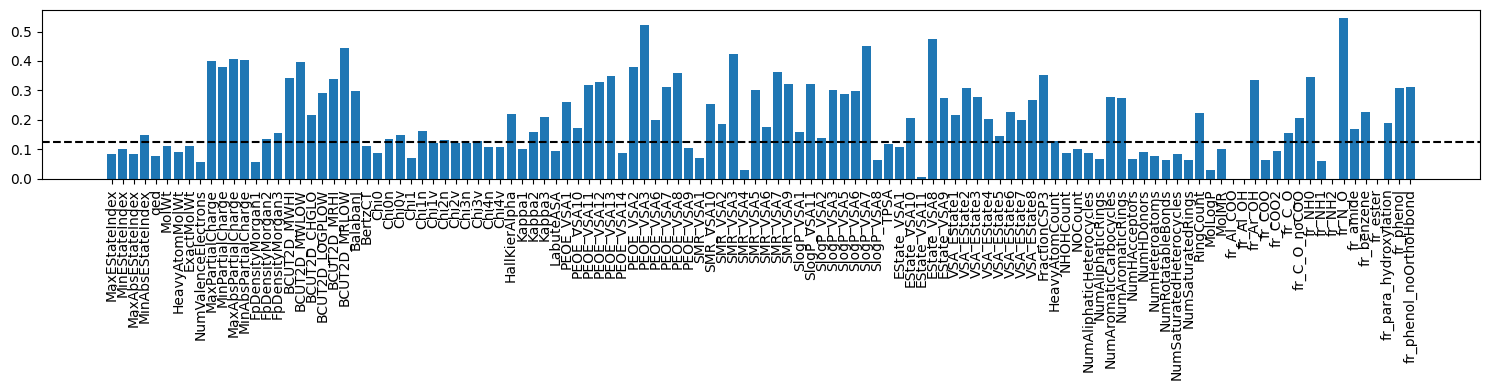

In [16]:
# Visualizamos la importancia de cada feature
plt.figure(figsize = (15,4))
plt.bar(siderophores_1.columns, importance)
plt.axhline(y = S, color = 'black', linestyle = '--')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [17]:
labels_IG = []
for value in list(zip(siderophores_1.columns, importance)):
  if value[1] >= S:
    labels_IG.append(value[0])
print('Features antes de IG: {}'.format(len(siderophores_1.columns)))
print('Features después de IG: {}'.format(len(labels_IG)))

Features antes de IG: 118
Features después de IG: 72


De los features encontrados, utilizaremos el text de chi cuadradado para determinar los 10 features que tienen mayor dependencia con la clase ([Rana & Signhal, 2015](https://www.j-pcs.org/article.asp?issn=2395-5414;year=2015;volume=1;issue=1;spage=69;epage=71;aulast=Rana)). En este sentido, un mayor valor de chi cuadrado implica mayor dependencia con la clase.

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

best_features = SelectKBest(score_func = chi2, k=10)
best_fit = best_features.fit(X[labels_IG], y)
df_scores = pd.DataFrame(best_fit.scores_)
df_columns= pd.DataFrame(labels_IG)

featureScores = pd.concat([df_columns, df_scores], axis = 1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(10, 'Score'))

                   Feature      Score
66                  fr_N_O  55.140692
62                fr_Ar_OH  46.491869
40             SlogP_VSA11  46.317377
70               fr_phenol  46.232586
71  fr_phenol_noOrthoHbond  45.772230
7              BCUT2D_MWHI  42.984233
38                SMR_VSA9  40.963263
69   fr_para_hydroxylation  36.191795
59  NumAromaticCarbocycles  35.157411
68              fr_benzene  35.157411


Finalmente, evaluaremos la correlación entre los 10 features encontrados.

<Axes: >

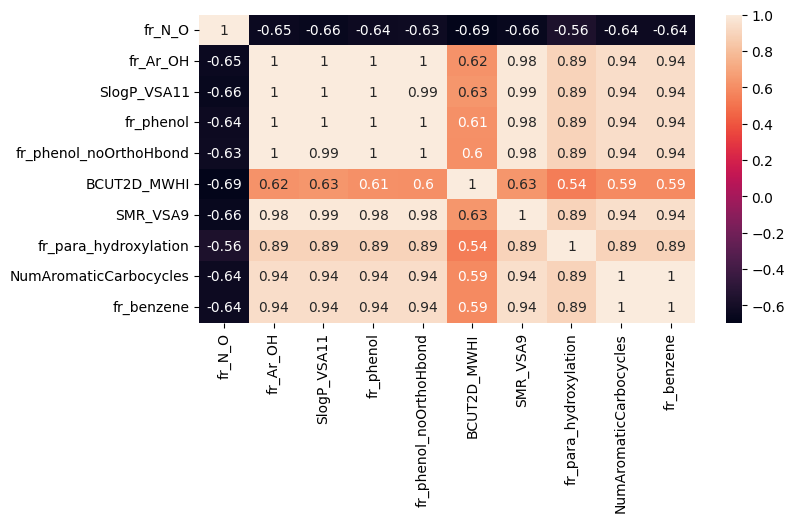

In [19]:
labels = featureScores.nlargest(10, 'Score')
labels = list(labels['Feature'])

import seaborn as sns
fig, ax = plt.subplots(figsize = (8,4))
sns.heatmap(X[labels].corr(), annot = True)

Al definir un valor umbral de 0.5, retiramos el feature *fr_N_O*

In [20]:
x = X[labels]
x = x.drop(x.columns[0], axis = 1)
x.head()

,fr_Ar_OH,SlogP_VSA11,fr_phenol,fr_phenol_noOrthoHbond,BCUT2D_MWHI,SMR_VSA9,fr_para_hydroxylation,NumAromaticCarbocycles,fr_benzene
0,0.333333,0.333333,0.333333,0.166667,0.950500,0.287748,0.333333,0.25,0.25
1,0.333333,0.333333,0.333333,0.333333,0.943377,0.287748,0.333333,0.25,0.25
2,0.333333,0.333333,0.333333,0.333333,0.883770,0.287748,0.333333,0.25,0.25
3,0.333333,0.333333,0.333333,0.333333,0.846136,0.287748,0.333333,0.25,0.25
4,0.166667,0.166667,0.166667,0.000000,0.885811,0.143874,0.333333,0.25,0.25


### Implementación del clasificador binario
Se utilizarán los siguientes clasificadores:
* Logistic Regression
* Decision Tree
* Support Vector Machine
* Random Forest
* K-Neares Neighbors
* XGBoost

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [22]:
clf = []

# Utilizaremos GridSearch para obtener los mejores parámetros para cada clasificador
from sklearn.model_selection import GridSearchCV

Implementamos un modelo de Regresión Logística como punto de referencia para la comparación de métricas, puesto que es el modelo de más sencilla implementación.

In [23]:
# Regresión Logística
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
clf.append(lr_clf)

Para seleccionar los hiperparámetros del árbol de decisión, se consideran los siguientes puntos:
* La literatura sugiere que, en general, no existe una diferencia en el desempeño de un árbol de decisión al comparar entre el criterio de splitting *gini* y *entropía* ([Hamza & Larocque, 2006](https://www.tandfonline.com/doi/abs/10.1080/00949650410001729472)). Se tomará por defecto el criterio *gini*
* `sklearn.tree.DecisionTreeClassifier `utiliza el algoritmo CART para implementar el árbol de decisión ([sklearn](https://scikit-learn.org/stable/modules/tree.html)). Luego, de acuerdo a [Mantovani et al (2018)](https://arxiv.org/abs/1812.02207), el rango óptimo de `min_samples_split` se encuentra entre 1 y 40, mientras que el rango de `min_samples_leaf` se encuentra entre 1 y 20.
* Para evitar overfitting, se asume como límite superior para el hiperparámetro `max_depth` el valor de 8 ([Alawad et al, 2018](https://ieeexplore.ieee.org/abstract/document/8527470))

In [24]:
# Árboles de decisión
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': [3, 5, 7],
              'min_samples_split': np.arange(2, 41),
              'min_samples_leaf': np.arange(1, 21)  
              }

tree_clf = DecisionTreeClassifier(criterion = 'gini')
tree_GS = GridSearchCV(tree_clf, param_grid) # default 5-cross validation
clf.append(tree_GS)

Para seleccionar los hiperparámetros del Support Vector Machine, se consideran los propuestos por [Sipper, 2022](https://arxiv.org/pdf/2207.06028.pdf).

In [25]:
# Support Vector Machine
from sklearn.svm import SVC

param_grid = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.001, 0.0001]} 

svm_clf = SVC()
svm_GS = GridSearchCV(svm_clf, param_grid)
clf.append(svm_GS)

Del mismo modo, para seleccionar los hiperparámetros del Random Forest, se consideran los propuestos por [Sipper, 2022](https://arxiv.org/pdf/2207.06028.pdf).

In [26]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10,50,100,200, 1000],
              'min_weight_fraction_leaf': [0.0, 0.5],
              'max_features': ['sqrt', 'log2']
              } 

rf_clf = RandomForestClassifier()
rf_GS = GridSearchCV(rf_clf, param_grid)
clf.append(rf_GS)

Se considera que el único hiperparámetro a optimizar para KNN es el número de K.

In [27]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(5,21),
              } 

knn_clf = KNeighborsClassifier()
knn_GS = GridSearchCV(knn_clf, param_grid)
clf.append(knn_GS)

Para el XGBoost, se consideran aquellos utilizados en [este](https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d) artículo de TowardsDataScience.

In [28]:
from xgboost import XGBClassifier

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth': [5,6,7,8],
              'n_estimators': [50,65,80,100,115,130,150],
              }

xgb_clf = XGBClassifier(objective="binary:logistic")
xgb_GS = GridSearchCV(xgb_clf, param_grid)
clf.append(xgb_GS)

In [29]:
# Fit 
for model in clf:
  model.fit(X_train, y_train)

Visualizamos los mejores parámetros de cada modelo (i.e resultado de GridSearch)

In [30]:
labels = ['Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest', 'KNN', 'XGBoost']
for i, model in enumerate(clf[1:]):
  print(labels[i+1])
  print(model.best_params_)
  print('\n')

Decision Tree
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 12}


SVM
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


Random Forest
{'max_features': 'log2', 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10}


KNN
{'n_neighbors': 5}


XGBoost
{'gamma': 1.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150}




In [31]:
#@title Métricas de desempeño
# Evaluamos las métricas accuracy, F1 score, precision, recall, curva AUC y la matriz de confusión
y_pred = [model.predict(X_test) for model in clf]
metrics = {'Accuracy':list(), 'F1 score':list(), 'Precision':list(), 'Recall':list()}

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

for j in range(len(y_pred)):
  metrics['Accuracy'].append(accuracy_score(y_test, y_pred[j]))
  metrics['F1 score'].append(f1_score(y_test, y_pred[j],))
  metrics['Precision'].append(precision_score(y_test, y_pred[j],))
  metrics['Recall'].append(recall_score(y_test, y_pred[j],))

df_metrics = pd.DataFrame(metrics)
df_metrics.insert(0, 'Clasificadores', labels)
df_metrics.set_index('Clasificadores', inplace=True)
print(df_metrics)

                     Accuracy  F1 score  Precision    Recall
Clasificadores                                              
Logistic Regression  0.892857  0.914286   0.941176  0.888889
Decision Tree        0.928571  0.942857   0.970588  0.916667
SVM                  0.928571  0.942857   0.970588  0.916667
Random Forest        0.910714  0.927536   0.969697  0.888889
KNN                  0.875000  0.898551   0.939394  0.861111
XGBoost              0.910714  0.929577   0.942857  0.916667


A excepción del modelo KNN, los algoritmos implementados superan el desempeño del modelo de Regresión Logística que se planteó al inicio como la base. Los modelos de árbol de decisión y support vector machine obtuvieron las métricas de desempeño más altos.

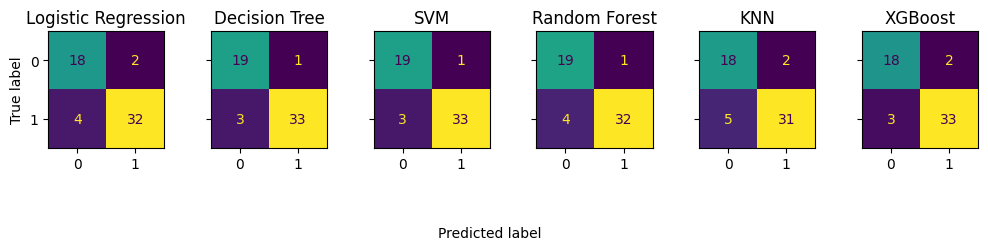

In [32]:
#@title Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest', 'KNN', 'XGBoost']

f, axes = plt.subplots(1, 6, figsize=(12, 5), sharey='row')

for i in range(6):
    cf_matrix = confusion_matrix(y_test, y_pred[i])
    disp = ConfusionMatrixDisplay(cf_matrix,)
    disp.plot(ax=axes[i],)
    disp.ax_.set_title(labels[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.2, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()

Observamos con más detalle el desempeño de cada modelo. Tanto el árbol de decisión como support vector machine ambos tiene ambos el menor número de falsos positivos y negativos, lo que se corresponde con un mayor desempeño (en cuestión de precisión y sensibilidad).

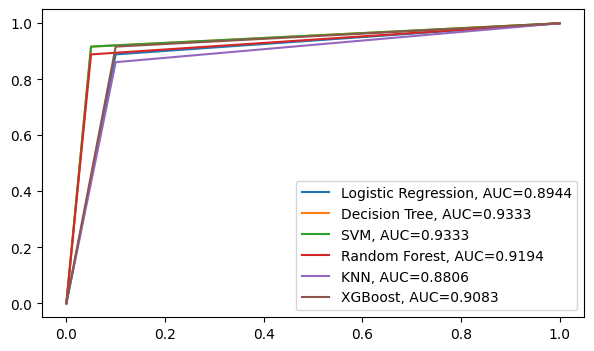

In [33]:
#@title Curvas ROC
from sklearn import metrics

plt.figure(figsize = (7,4))

for i in range(6):
  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred[i])
  auc = round(metrics.roc_auc_score(y_test, y_pred[i]), 4)
  plt.plot(fpr,tpr,label=f"{labels[i]}, AUC="+str(auc))

plt.legend()
plt.show()

Las curvas ROC complementan el análisis realizado anteriormente.

## Clasificación múltiple de sideróforos

Si evaluamos el dataset *Siderophores_DB.csv*, observamos como existen compuestos que, a la vez, presentan más de un grupo funcional. 

In [34]:
siderophores_0.iloc[0, 3:10]

hydroxamate             0
catecholate             1
a-hydroxycarboxylate    0
carboxylate             1
phenolate               0
citrate                 0
other                   0
Name: 0, dtype: object

Por lo tanto, nos encontramos ante un problema *multiclass-multioutput*. Ante ello, la [librería sklearn](https://scikit-learn.org/stable/modules/multiclass.html) sugiere utilizar los siguientes modelos:
* tree.DecisionTreeClassifier
* neighbors.KNeighborsClassifier
* ensemble.RandomForestClassifier

Sin embargo, por simplicidad, buscaremos si existen dos grupos funcionales que no se compartan entre el mismo compuesto. Es decir que, para todos los microorganismos, cuando uno de dichos grupos funcionales está presente, el otro no. Los denominamos ortogonales

In [35]:
def orthogonal(constant, change):
  for i, value in enumerate(siderophores_0[constant]):
    if (value != 0) and (siderophores_0[change][i] != 0):
      print('Not  son ortogonales')
      break
    if  i == (221-1):
      print(f'{constant} y {change} son ortogonales\n') 
    
tags = siderophores_0.iloc[:,3:10]
orthogonal(tags.keys()[2], tags.keys()[4])
orthogonal(tags.keys()[4], tags.keys()[5])

a-hydroxycarboxylate y phenolate son ortogonales

phenolate y citrate son ortogonales



Evaluamos el balance de clases entre ambos.

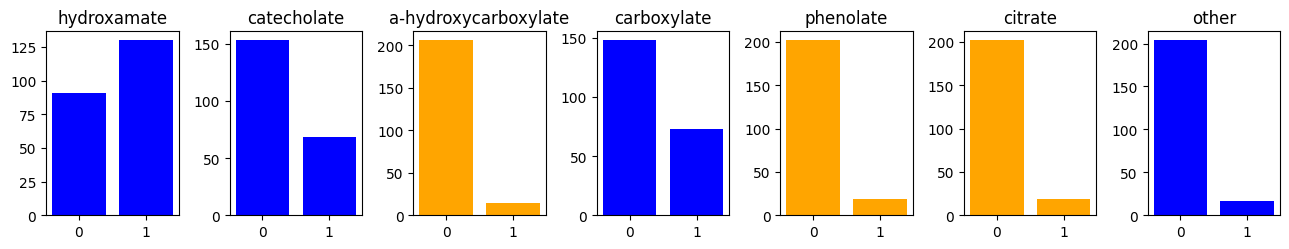

In [36]:
fig, axs = plt.subplots(1,7, figsize = (13,2.6))
for i, key in enumerate(siderophores_0.keys()[3:10]):
  _, counts = np.unique(siderophores_0[key], return_counts=True)
  if (i==2) or (i==4) or (i==5):
    axs[i].bar([0,1], [counts[0], np.sum(counts[1:])], color = 'orange')
  else:
    axs[i].bar([0,1], [counts[0], np.sum(counts[1:])], color = 'blue')
  axs[i].set_title(key)
plt.tight_layout()
plt.show()

En este caso, no sería conveniente realizar un *upsample* debido a la magnitud del desbalance (e.g para a-hydroxycarboxylate, la data que corresponde a la clase '1' es el 7% del total). De la misma forma, tampoco sería conveniente un *downsample* debido a la gran pérdida de información que existiría. Por lo tanto, se considerarán como métricas el F1 score para compensar por este desbalance, el cual será analizado a partir de las métricas de desempeño de los modelos implementados.

In [37]:
# Como las clases 'fenolato' y 'citrato' son ortogonales, el único caso donde ambos tendrían el mismo valor sería
# cuando el compuesto no tiene ninguno de estos grupos (i.e  0 y 0)
np.sum(tags['phenolate'] == tags['citrate'])

183

Por lo tanto, tendremos las siguientes clases: '0': el compuesto no tiene ni citrato ni fenolato, '1': el compuesto tiene fenolato, y '2': el compuesto tiene citrato

In [38]:
# Codificando el target
y = []
for i in range(len(tags['phenolate'])):
  if tags['phenolate'][i] > 0:
    y.append(1)
  elif tags['citrate'][i] > 0:
    y.append(2)
  else:
    y.append(0)

In [39]:
# Trabajamos con los mismos features de la clasificación binaria
X = x

# Realizamos el split de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [40]:
#@title Implementación del clasificador múltiple

# Implementamos los modelos que permiten una clasificación múltiple
# Utilizaremos los mejores parámetros del experimento anterior

clf_multi = []

# Regresión Logística
multi_lr_clf = LogisticRegression(multi_class = 'multinomial')
clf_multi.append(multi_lr_clf)

# Árbol de decisión
multi_tree_clf = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 3,
                                  min_samples_leaf = 1,
                                  min_samples_split = 22)
clf_multi.append(multi_tree_clf)

# K-nearest neighbors
multi_knn_clf = KNeighborsClassifier(n_neighbors = 5)

clf_multi.append(multi_knn_clf)

# Random Forest
multi_rf_clf = RandomForestClassifier(max_features = 'sqrt',
                                      min_weight_fraction_leaf = 0.0,
                                      n_estimators = 50)
clf_multi.append(multi_rf_clf)

# Naive Bayes: ComplementNB funciona en datasets con desbalance
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB
from sklearn.naive_bayes import ComplementNB
multi_nb_clf = ComplementNB()

clf_multi.append(multi_nb_clf)

# XGBoost
multi_xgb_clf = XGBClassifier(objective="multi:softprob",
                              gamma = 1.6,
                              learning_rate = 0.01,
                              max_depth = 5,
                              n_estimators = 150)
clf_multi.append(multi_xgb_clf)

In [41]:
# Fit 
for model in clf_multi:
  model.fit(X_train, y_train)

In [42]:
#@title Métricas de desempeño
# Evaluamos las métricas accuracy, F1 score, precision, recall, curva AUC y la matriz de confusión
labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest', 'Naive Bayes', 'XGBoost']

y_pred = [model.predict(X_test) for model in clf_multi]
metrics = {'Accuracy':list(), 'F1 score':list(), 'Precision':list(), 'Recall':list()}

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

for j in range(len(y_pred)):
  metrics['Accuracy'].append(accuracy_score(y_test, y_pred[j]))
  metrics['F1 score'].append(f1_score(y_test, y_pred[j], average = 'weighted'))
  metrics['Precision'].append(precision_score(y_test, y_pred[j], average = 'weighted'))
  metrics['Recall'].append(recall_score(y_test, y_pred[j], average = 'weighted'))

df_metrics = pd.DataFrame(metrics)
df_metrics.insert(0, 'Clasificadores', labels)
df_metrics.set_index('Clasificadores', inplace=True)
print(df_metrics)

                     Accuracy  F1 score  Precision    Recall
Clasificadores                                              
Logistic Regression  0.892857  0.842318   0.797194  0.892857
Decision Tree        0.857143  0.824176   0.793651  0.857143
KNN                  0.910714  0.895943   0.914757  0.910714
Random Forest        0.910714  0.895943   0.914757  0.910714
Naive Bayes          0.357143  0.446838   0.900579  0.357143
XGBoost              0.910714  0.895943   0.914757  0.910714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


En este caso, el valor de *accuracy* como el área debajo de la curva ROC no son métricas confiables debido al desbalance de datos. Siendo el F1 score la métrica más adecuada para este caso, podemos suponer que los modelos KNN, Random Forest y XGBoost tienen el mejor desempeño para diferenciar entre un compuesto con citrato, fenolato o ninguno. Sin embargo, por el desbalance de datos, será necesario revisar la matriz de confusión.

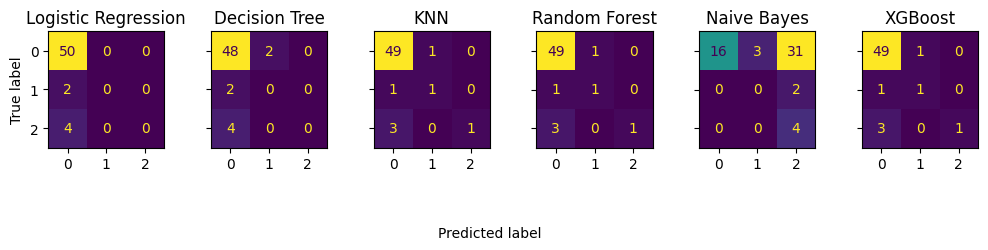

In [43]:
#@title Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest', 'Naive Bayes', 'XGBoost']

f, axes = plt.subplots(1, 6, figsize=(12, 5), sharey='row')

for i in range(6):
    cf_matrix = confusion_matrix(y_test, y_pred[i])
    disp = ConfusionMatrixDisplay(cf_matrix,)
    disp.plot(ax=axes[i],)
    disp.ax_.set_title(labels[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.2, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()

Con la matriz de confusión se hace evidente el efecto del desbalance de datos en el desempeño de los modelos. En este caso, realmente ninguno de los modelos es capaz de predecir correctamente las clases. Si lo comparamos con un clasificador aleatorio:

In [44]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Dummy']

metrics['Accuracy'].append(accuracy_score(y_test, dummy_clf.predict(X_test)))
metrics['F1 score'].append(f1_score(y_test, dummy_clf.predict(X_test), average = 'weighted'))
metrics['Precision'].append(precision_score(y_test, dummy_clf.predict(X_test), average = 'weighted'))
metrics['Recall'].append(recall_score(y_test, dummy_clf.predict(X_test), average = 'weighted'))

df_metrics = pd.DataFrame(metrics)
df_metrics.insert(0, 'Clasificadores', labels)
df_metrics.set_index('Clasificadores', inplace=True)
print(df_metrics)

                     Accuracy  F1 score  Precision    Recall
Clasificadores                                              
Logistic Regression  0.892857  0.842318   0.797194  0.892857
Decision Tree        0.857143  0.824176   0.793651  0.857143
KNN                  0.910714  0.895943   0.914757  0.910714
Random Forest        0.910714  0.895943   0.914757  0.910714
Naive Bayes          0.357143  0.446838   0.900579  0.357143
XGBoost              0.910714  0.895943   0.914757  0.910714
Dummy                0.892857  0.842318   0.797194  0.892857


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Demostramos que reamente los modelos no son capaces de realizar una predicción correcta debido al desbalance de datos.

<Figure size 400x400 with 0 Axes>

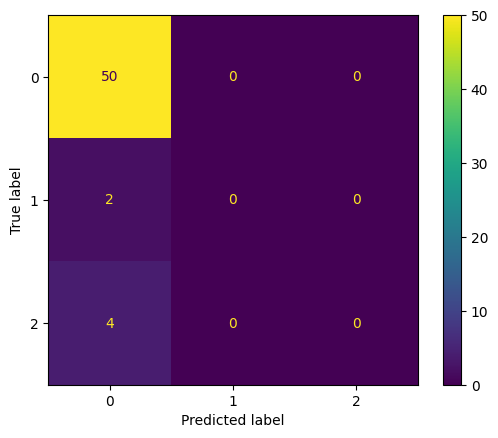

In [45]:
# Matriz de confusión
plt.figure(figsize = (4,4))
cf_matrix = confusion_matrix(y_test, dummy_clf.predict(X_test))
disp = ConfusionMatrixDisplay(cf_matrix,)
disp.plot()
plt.show()

Observamos la similitud de la matriz de confusión del *dummy classifier* con los demás modelos.

## Observaciones

* No se obtuvo un resultado satisfactorio para la clasificación múltiple de sideróforos. Esto debido al desbalance de clases que existe entre las clases definidas como ortogonales. Podría implementarse un modelo que sea capaz de clasificar inputs que pertenecen a más de una clase y trabajar con los demás grupos funcionales de sideróforos (e.g sección *1.12.3. Multiclass-multioutput classification* de la documentación de [scikit-learn](https://scikit-learn.org/stable/modules/multiclass.html)
* Puede repetirse el análisis presentado para el dataset *Siderophores_DB1.csv* para los demás descriptores moleculares, y comparar qué features describen mejor a los grupos funcionales